# Neural Networks and Deep Learning - Exercise 2

Name: Elad Shoham

ID: 206001752

# Imports and Definitions

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
dim = 2
out_dim = 1
T = 0.5
max_epocs = 40000

x_train = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], requires_grad=True, dtype=torch.float32)
t_train = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

x_test = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1], [1, .1], [1, .9], [.9, .9], [.1, .9]], requires_grad=True, dtype=torch.float32)
t_test = torch.tensor([[0], [1], [1], [0], [1], [0], [0], [1]], dtype=torch.float32)

# Define Classes and Functions

In [ ]:
class Linear(torch.nn.Module):
  def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
    factory_kwargs = {'device': device, 'dtype': dtype}
    super(Linear, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
    if bias:
        self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self) -> None:
    self.weight = nn.Parameter(torch.rand([self.out_features, self.in_features]))
    if self.bias is not None:
      self.bias = nn.Parameter(torch.rand([self.out_features]))

  def forward(self, input: torch.Tensor) -> torch.Tensor:
    return torch.matmul(input, torch.transpose(self.weight, 0, 1)) + self.bias

  def extra_repr(self) -> str:
    return 'in_features={}, out_features={}, bias={}'.format(
        self.in_features, self.out_features, self.bias is not None
      )
  

In [ ]:
class BTU(torch.nn.Module):
  def __init__(self, T=0.2, inplace: bool = False):
      super(BTU, self).__init__()
      self.T = T

  def forward(self, input: torch.Tensor) -> torch.Tensor:
      return 1 / (1 + torch.exp(-input/self.T))

In [ ]:
class XOR_Net_Model(torch.nn.Module):
  def __init__(self, num_hidden, bypass=True, print_hidden=False):
    super().__init__()
    self.bypass = bypass
    self.hidden = Linear(dim, num_hidden)
    if self.bypass:
      self.output = Linear(num_hidden + dim, out_dim)
    else:
      self.output = Linear(num_hidden, out_dim)
    self.BTU = BTU(T)
    self.print_hidden = print_hidden

  def reset_parameters(self) -> None:
    self.hidden.reset_parameters()
    self.output.reset_parameters()

  def forward(self, input):
    z1 = self.hidden(input)
    y1 = self.BTU(z1)
    if self.bypass:
      y1_concat = torch.cat((input, y1), 1)
      if (self.print_hidden):
        print(y1_concat)
      z2 = self.output(y1_concat)
    else:
      z2 = self.output(y1)
    return self.BTU(z2)

In [ ]:
# Cross Entropy loss function
def Loss(out, t_train):
  return -torch.sum(t_train * torch.log(out) + (1.0 - t_train) * torch.log(1.0 - out))

In [ ]:
def train(model, x_train, t_train, optimizer):
  y_pred = model(x_train)
  loss = Loss(y_pred, t_train)
  # zero gradients berfore running the backward pass
  optimizer.zero_grad()

  # backward pass to compute the gradient of loss
  # backprop + accumulate 
  loss.backward()

  # update params
  optimizer.step()
  return loss

In [ ]:
# define test step operation:
def test(model, x_test, t_test):
  return Loss(model(x_test), t_test)

In [ ]:
def experiment(model, l_rate):
  runs_details = { 'epochs': [], 'trains_loss': [], 'validations_loss': [], 'failed_runs': 0 } 
  successful_runs = 0

  while successful_runs < 10:
    model.reset_parameters()
    optimizer = torch.optim.SGD(model.parameters(), lr=l_rate)
    last_ten_loss = []
    is_successful_run = False

    for i in range(max_epocs):
      train_loss = train(model, x_train, t_train, optimizer)
      last_ten_loss.append(train_loss)

      if len(last_ten_loss) > 10 and last_ten_loss.pop(0) - train_loss < 0.0001 and train_loss < 0.2:
        is_successful_run = True
        break

    if is_successful_run:
      runs_details['epochs'].append(i + 1)
      runs_details['trains_loss'].append(train_loss.item())
      runs_details['validations_loss'].append(test(model, x_test, t_test).item())
      successful_runs += 1
    else:
      runs_details['failed_runs'] += 1
  
  runs_details['epochs_avg'] = np.average(runs_details['epochs'])
  runs_details['epochs_std'] = np.std(runs_details['epochs'])
  runs_details['trains_loss_avg'] = np.average(runs_details['trains_loss'])
  runs_details['trains_loss_std'] = np.std(runs_details['trains_loss'])
  runs_details['validations_loss_avg'] = np.average(runs_details['validations_loss'])
  runs_details['validations_loss_std'] = np.std(runs_details['validations_loss'])

  return runs_details

In [ ]:
def print_experiment(runs_details):
  print('Epochs')
  print('Average:', runs_details['epochs_avg'])
  print('Standard deviation:', runs_details['epochs_std'])
  print('Train loss')
  print('Average:', runs_details['trains_loss_avg'])
  print('Standard deviation:', runs_details['trains_loss_std'])
  print('Validation loss')
  print('Average:', runs_details['validations_loss_avg'])
  print('Standard deviation:', runs_details['validations_loss_std'])
  print('Failed runs:', runs_details['failed_runs'])

In [ ]:
def show_graph(x, y, x_label, y_label, title):
  plt.scatter(x, y)
  plt.plot(x, y, '+-r')
  plt.grid()
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

# Experiments

In [ ]:
epochs_averages = []
epochs_stds = []
learning_rates = []
nums_hidden = []
have_bypass = []

In [ ]:
def run_experiment(l_rate, num_hidden, bypass):
  model = XOR_Net_Model(num_hidden, bypass, num_hidden == 1 and bypass)
  for param in model.parameters():
    print(param)

  runs_details = experiment(model, l_rate)
  print_experiment(runs_details)

  epochs_averages.append(runs_details['epochs_avg'])
  epochs_stds.append(runs_details['epochs_std'])
  learning_rates.append(l_rate)
  nums_hidden.append(num_hidden)
  have_bypass.append(bypass)

**Experiment 1**

Learning rate = 0.01

Number of hidden neurons = 2

Bypass = True

In [ ]:
run_experiment(l_rate = 0.01, num_hidden = 2, bypass = True)

Parameter containing:
tensor([[0.0643, 0.8607],
        [0.8326, 0.9255]], requires_grad=True)
Parameter containing:
tensor([0.9450, 0.4649], requires_grad=True)
Parameter containing:
tensor([[0.4945, 0.6325, 0.8140, 0.9126]], requires_grad=True)
Parameter containing:
tensor([0.5310], requires_grad=True)
Epochs
Average: 9123.3
Standard deviation: 1138.963392739205
Train loss
Average: 0.06988544203341007
Standard deviation: 0.008427649150449776
Validation loss
Average: 0.26818267703056337
Standard deviation: 0.038301815883578505
Failed runs: 0


**Experiment 2**

Learning rate = 0.01

Number of hidden neurons = 2

Bypass = False

In [ ]:
run_experiment(l_rate = 0.01, num_hidden = 2, bypass = False)

Parameter containing:
tensor([[0.6355, 0.4057],
        [0.1449, 0.5542]], requires_grad=True)
Parameter containing:
tensor([0.6309, 0.5736], requires_grad=True)
Parameter containing:
tensor([[0.5926, 0.4423]], requires_grad=True)
Parameter containing:
tensor([0.1162], requires_grad=True)
Epochs
Average: 8069.5
Standard deviation: 946.7484618418981
Train loss
Average: 0.05108712278306484
Standard deviation: 0.0052227228779580855
Validation loss
Average: 0.14488957226276397
Standard deviation: 0.0058419091504181165
Failed runs: 12


**Experiment 3**

Learning rate = 0.01

Number of hidden neurons = 4

Bypass = True

In [ ]:
run_experiment(l_rate = 0.01, num_hidden = 4, bypass = True)

Parameter containing:
tensor([[0.1220, 0.6630],
        [0.7832, 0.0665],
        [0.6598, 0.7994],
        [0.0356, 0.8784]], requires_grad=True)
Parameter containing:
tensor([0.6960, 0.7594, 0.4203, 0.8224], requires_grad=True)
Parameter containing:
tensor([[0.1220, 0.9631, 0.5126, 0.5614, 0.4555, 0.5433]], requires_grad=True)
Parameter containing:
tensor([0.6967], requires_grad=True)
Epochs
Average: 7561.0
Standard deviation: 624.5217370116112
Train loss
Average: 0.0550773449242115
Standard deviation: 0.005191200844537929
Validation loss
Average: 0.20703951716423036
Standard deviation: 0.03276390625622544
Failed runs: 0


**Experiment 4**

Learning rate = 0.01

Number of hidden neurons = 4

Bypass = False

In [ ]:
run_experiment(l_rate = 0.01, num_hidden = 4, bypass = False)

Parameter containing:
tensor([[0.8943, 0.1616],
        [0.1604, 0.5235],
        [0.7084, 0.5486],
        [0.2578, 0.4634]], requires_grad=True)
Parameter containing:
tensor([0.4551, 0.4284, 0.7715, 0.3315], requires_grad=True)
Parameter containing:
tensor([[0.2385, 0.6024, 0.8863, 0.9225]], requires_grad=True)
Parameter containing:
tensor([0.2195], requires_grad=True)
Epochs
Average: 8377.7
Standard deviation: 1186.7872640031153
Train loss
Average: 0.052533477544784546
Standard deviation: 0.004400866503276425
Validation loss
Average: 0.15167783051729203
Standard deviation: 0.008829407616432446
Failed runs: 0


**Experiment 5**

Learning rate = 0.1

Number of hidden neurons = 2

Bypass = True

In [ ]:
run_experiment(l_rate = 0.1, num_hidden = 2, bypass = True)

Parameter containing:
tensor([[0.2906, 0.0844],
        [0.3991, 0.0060]], requires_grad=True)
Parameter containing:
tensor([0.6846, 0.8398], requires_grad=True)
Parameter containing:
tensor([[0.1145, 0.3826, 0.6885, 0.8772]], requires_grad=True)
Parameter containing:
tensor([0.1377], requires_grad=True)
Epochs
Average: 2281.9
Standard deviation: 249.60667058394094
Train loss
Average: 0.019022813253104686
Standard deviation: 0.0014048131614397016
Validation loss
Average: 0.08469204306602478
Standard deviation: 0.0182974281461775
Failed runs: 0


**Experiment 6**

Learning rate = 0.1

Number of hidden neurons = 2

Bypass = False

In [ ]:
run_experiment(l_rate = 0.1, num_hidden = 2, bypass = False)

Parameter containing:
tensor([[0.3230, 0.3181],
        [0.0273, 0.6655]], requires_grad=True)
Parameter containing:
tensor([0.5078, 0.0953], requires_grad=True)
Parameter containing:
tensor([[0.1844, 0.2933]], requires_grad=True)
Parameter containing:
tensor([0.4861], requires_grad=True)
Epochs
Average: 1870.9
Standard deviation: 50.62104305523544
Train loss
Average: 0.015280833747237921
Standard deviation: 1.3049998008447319e-05
Validation loss
Average: 0.04652522876858711
Standard deviation: 0.00014017885935223238
Failed runs: 3


**Experiment 7**

Learning rate = 0.1

Number of hidden neurons = 4

Bypass = True

In [ ]:
run_experiment(l_rate = 0.1, num_hidden = 4, bypass = True)

Parameter containing:
tensor([[0.5821, 0.0712],
        [0.6669, 0.3487],
        [0.8603, 0.7724],
        [0.2615, 0.4842]], requires_grad=True)
Parameter containing:
tensor([0.0765, 0.2345, 0.0602, 0.5564], requires_grad=True)
Parameter containing:
tensor([[0.6677, 0.0845, 0.3294, 0.4105, 0.5555, 0.7940]], requires_grad=True)
Parameter containing:
tensor([0.0224], requires_grad=True)
Epochs
Average: 2006.6
Standard deviation: 230.15221050426607
Train loss
Average: 0.01661670785397291
Standard deviation: 0.0015192610501900488
Validation loss
Average: 0.0751679927110672
Standard deviation: 0.010795288594619049
Failed runs: 0


**Experiment 8**

Learning rate = 0.1

Number of hidden neurons = 4

Bypass = False

In [ ]:
run_experiment(l_rate = 0.1, num_hidden = 4, bypass = False)

Parameter containing:
tensor([[0.6377, 0.7221],
        [0.6996, 0.8331],
        [0.9771, 0.6009],
        [0.7129, 0.9992]], requires_grad=True)
Parameter containing:
tensor([0.1628, 0.7907, 0.4447, 0.1822], requires_grad=True)
Parameter containing:
tensor([[0.9369, 0.4867, 0.5448, 0.1482]], requires_grad=True)
Parameter containing:
tensor([0.5416], requires_grad=True)
Epochs
Average: 1928.5
Standard deviation: 387.0018733804786
Train loss
Average: 0.01546206446364522
Standard deviation: 0.0017864794242601159
Validation loss
Average: 0.04752004109323025
Standard deviation: 0.003070730215105939
Failed runs: 0


**Experiment 9**

Learning rate = 0.05

Number of hidden neurons = 1

Bypass = True

In [ ]:
run_experiment(l_rate = 0.05, num_hidden = 1, bypass = True)

Streaming output truncated to the last 5000 lines.
        [1.0000, 0.0000, 0.9923],
        [1.0000, 1.0000, 1.0000]], grad_fn=<CatBackward>)
tensor([[0.0000, 0.0000, 0.0239],
        [0.0000, 1.0000, 0.9923],
        [1.0000, 0.0000, 0.9923],
        [1.0000, 1.0000, 1.0000]], grad_fn=<CatBackward>)
tensor([[0.0000, 0.0000, 0.0238],
        [0.0000, 1.0000, 0.9923],
        [1.0000, 0.0000, 0.9923],
        [1.0000, 1.0000, 1.0000]], grad_fn=<CatBackward>)
tensor([[0.0000, 0.0000, 0.0238],
        [0.0000, 1.0000, 0.9923],
        [1.0000, 0.0000, 0.9923],
        [1.0000, 1.0000, 1.0000]], grad_fn=<CatBackward>)
tensor([[0.0000, 0.0000, 0.0238],
        [0.0000, 1.0000, 0.9923],
        [1.0000, 0.0000, 0.9923],
        [1.0000, 1.0000, 1.0000]], grad_fn=<CatBackward>)
tensor([[0.0000, 0.0000, 0.0238],
        [0.0000, 1.0000, 0.9923],
        [1.0000, 0.0000, 0.9923],
        [1.0000, 1.0000, 1.0000]], grad_fn=<CatBackward>)
tensor([[0.0000, 0.0000, 0.0238],
        [0.0000, 1.0000

As we can see from the train, the hidden neuron acts like OR function.

OR truth table:

A | B | Target
--- | --- | ---
0 | 0 | 0
0 | 1 | 1
1 | 0 | 1
1 | 1 | 1


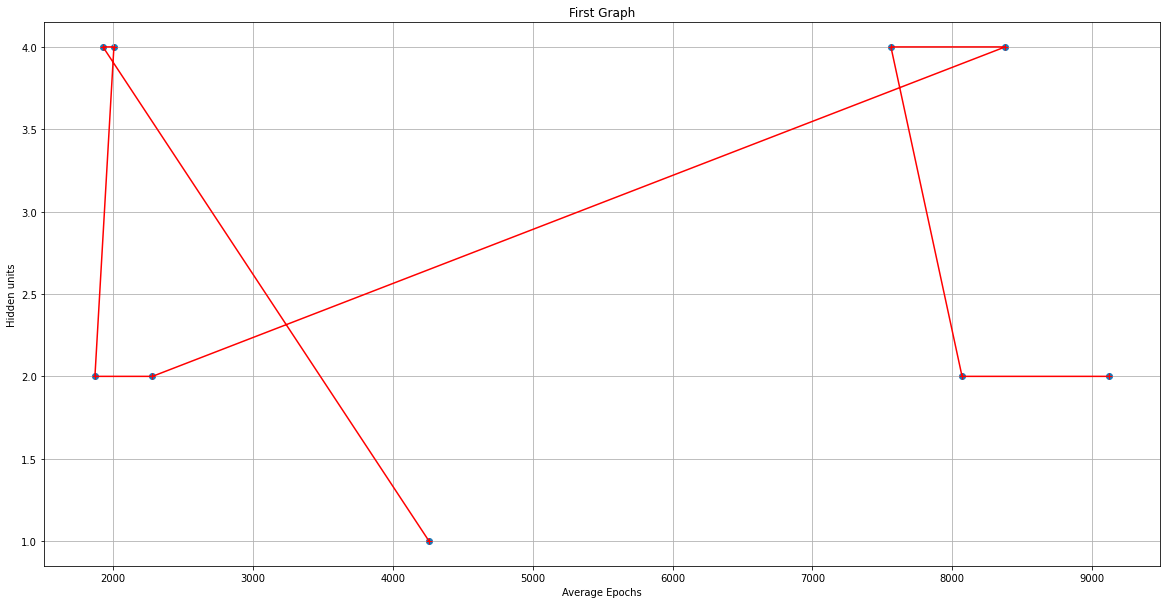

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10)

show_graph(epochs_averages, nums_hidden, 'Average Epochs', 'Hidden units', 'First Graph')

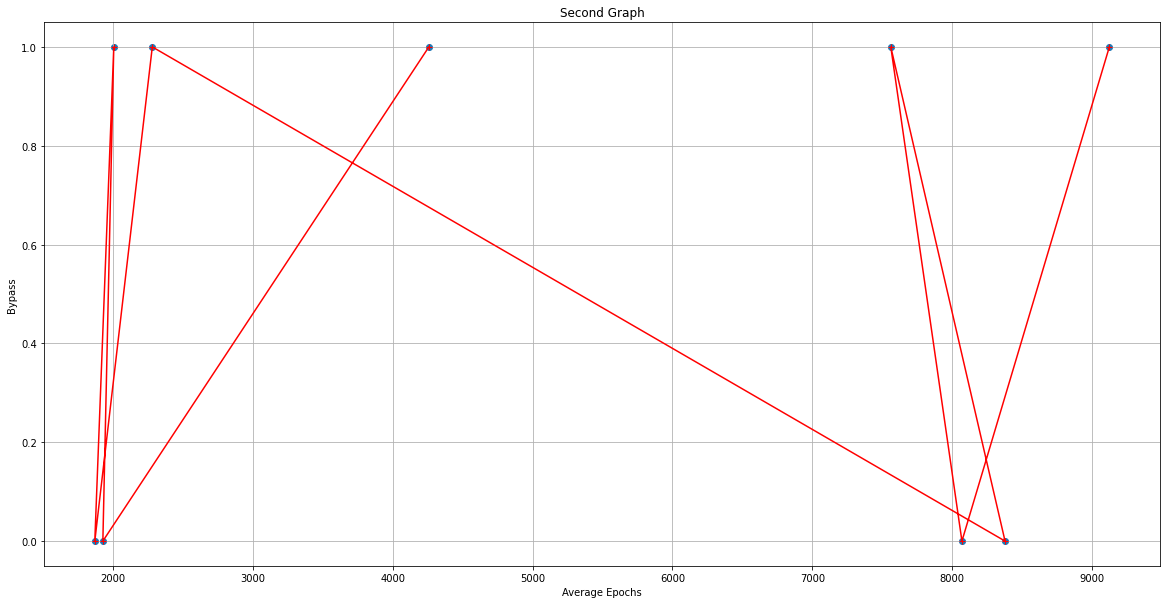

In [ ]:
show_graph(epochs_averages, have_bypass, 'Average Epochs', 'Bypass', 'Second Graph')

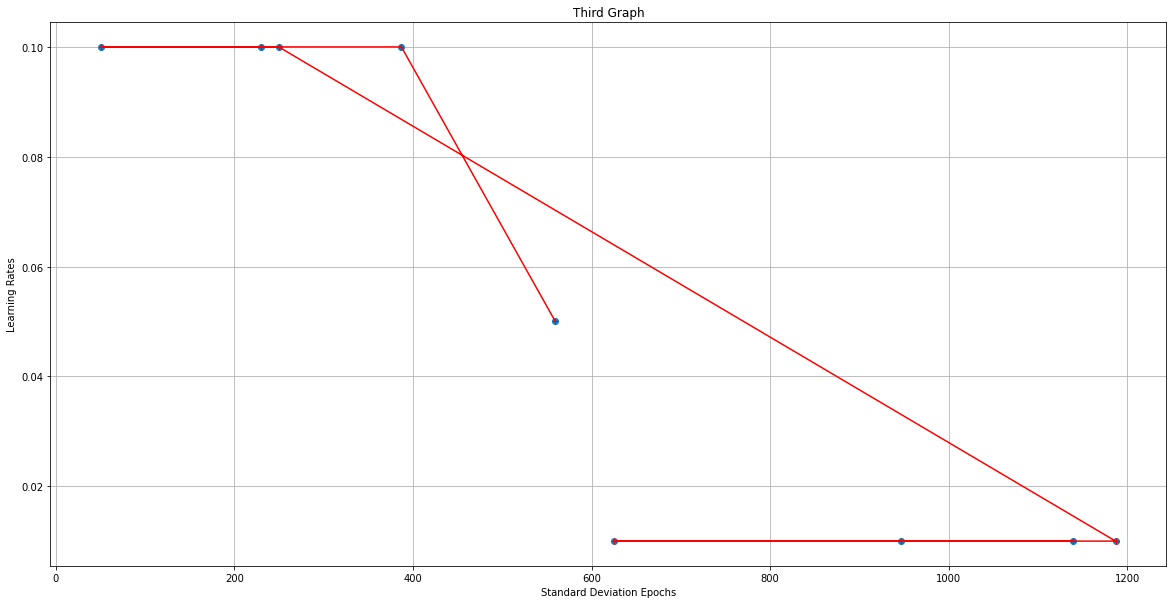

In [ ]:
show_graph(epochs_stds, learning_rates, 'Standard Deviation Epochs', 'Learning Rates', 'Third Graph')

# Conclusions

**First Graph**

Average epochs less depend on hidden units.

**Second Graph**

Average epochs less depend on bypass.

**Third Graph**

The higher the learning rate, the smaller the standard deviation.